In [1]:
import os
import glob

import DESutils
import GPRutils
import vK2KGPR
import plotGPR
import vK2KGPR
import vonkarmanFT as vk

import numpy as np
import astropy.units as u
import astropy.table as tb
from astropy.time import Time
import matplotlib.pyplot as plt
plt.style.use('~/GitHub/custom-matplotlib/custom.mplstyle')
import astropy.stats as stats
from scipy.signal import savgol_filter

from IPython import embed
from importlib import reload
import warnings
warnings.filterwarnings("ignore")

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
FITSfiles = sorted(glob.glob(f"/home/fortino/GPRSolutions/zone134/GPR.??????.?RC.fits"))
FITSfiles += sorted(glob.glob(f"/home/fortino/GPRSolutions/zone133/GPR.??????.?RC.fits"))
FITSfiles += sorted(glob.glob(f"/home/fortino/GPRSolutions/zone132/GPR.??????.?RC.fits"))
FITSfiles += sorted(glob.glob(f"/home/fortino/GPRSolutions/eris/GPR.??????.?RC.fits"))
print(len(FITSfiles))

343


In [3]:
%%time
AP = plotGPR.AggregatePlots(FITSfiles)
AP.calcVals()

CPU times: user 2min 24s, sys: 7.85 s, total: 2min 32s
Wall time: 3min 7s


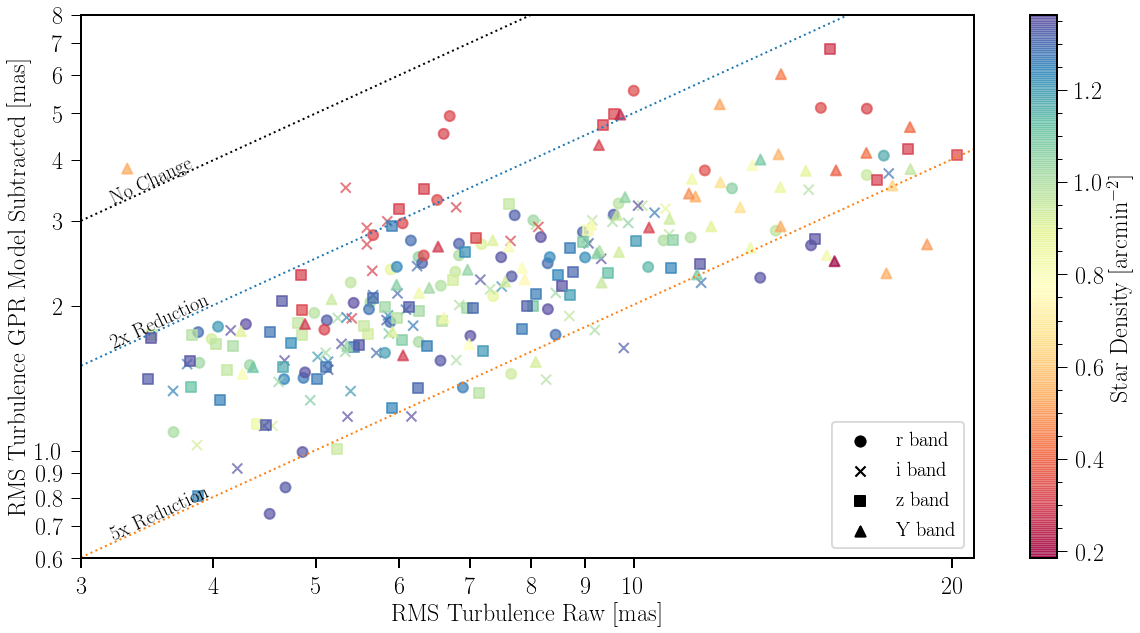

In [4]:
def xiBA2(
    AP,
    passband,
    annotate=False,
    save=None,
    xlim=(None, None),
    ylim=(None, None)
        ):
    framealpha = 0.5

    fig = plt.figure(figsize=(20, 10))
    plt.yscale("log")
    plt.xscale("log")

    bandHandles = []
    RMS_raw = []
    RMS_GPR = []
    RMSerr_raw = []
    RMSerr_GPR = []
    starDensity = []
    for band in plotGPR.DES_PASSBANDS:

        # Check if the current band in the loop is one of the bands in the list passband.
        if band not in passband:
            continue

        # If there are no exposures for that band in AP, then skip it.
        if len(AP.expNums[band]) == 0:
            continue
        
        # Collect the raw and GPR RMS values
        RMS_raw.extend(AP.RMS_raw[band])
        RMS_GPR.extend(AP.RMS_GPR[band])

        # Collect the raw and GPR RMS error values
        RMSerr_raw.extend(AP.RMSerr_raw[band])
        RMSerr_GPR.extend(AP.RMSerr_GPR[band])
        
        # Collect the star densities
        starDensity.extend(u.Quantity(AP.starDensity[band]).value)
        
        # Sigma clip on the errors for the raw RMS
        maskraw = stats.sigma_clip(AP.RMSerr_raw[band], sigma=5).mask
#         print(np.array(AP.RMS_raw[band])[maskraw])
        avgRMS_raw = np.mean(np.array(AP.RMS_raw[band])[~maskraw])
        avgRMSErr_raw = np.sqrt(np.sum(np.power(np.array(AP.RMS_raw[band])[~maskraw], 2)))
        avgRMSErr_raw /= len(np.array(AP.RMS_raw[band])[~maskraw])
        
        # Sigma clip on the errors for the fitted RMS
        maskGPR_fC = stats.sigma_clip(AP.RMSerr_GPR_fC[band], sigma=5).mask
#         print(np.array(AP.RMS_GPR_fC[band])[maskGPR_fC])
        avgRMS_GPR_fC = np.mean(np.array(AP.RMS_GPR_fC[band])[~maskGPR_fC])
        avgRMSErr_GPR_fC = np.sqrt(np.sum(np.power(np.array(AP.RMS_GPR_fC[band])[~maskGPR_fC], 2)))
        avgRMSErr_GPR_fC /= len(np.array(AP.RMS_GPR_fC[band])[~maskGPR_fC])

        # Sigma clip on the errors for the GPR RMS
        maskGPR = stats.sigma_clip(AP.RMSerr_GPR[band], sigma=5).mask
#         print(np.array(AP.RMS_GPR[band])[maskGPR])
        avgRMS_GPR = np.mean(np.array(AP.RMS_GPR[band])[~maskGPR])
        avgRMSErr_GPR = np.sqrt(np.sum(np.power(np.array(AP.RMS_GPR[band])[~maskGPR], 2)))
        avgRMSErr_GPR /= len(np.array(AP.RMS_GPR[band])[~maskGPR])

        # Create the legend handle for the current band in the for loop. This scatter point is
        # arbitrary and is just used to put a label in the legend for the band.
#         bandHandle = plt.scatter(
#             -1, 0,
#             alpha=1,
# #             color=plotGPR.DES_COLORS[band],
#             color="k",
#             marker=plotGPR.DES_MARKERS[band],
#             label=f"DES Passband {band}"
#                   f"\nMean RMS (Raw): {avgRMS_raw:.3f} ± {avgRMSErr_raw:.3f} mas"
#                   f"\nMean RMS (Fit): {avgRMS_GPR_fC:.3f} ± {avgRMSErr_GPR_fC:.3f} mas"
#                   f"\nMean RMS (GPR): {avgRMS_GPR:.3f} ± {avgRMSErr_GPR:.3f} mas"
#                 )
        bandHandle = plt.scatter(
            -1, 0,
            alpha=1,
            color="k",
            marker=plotGPR.DES_MARKERS[band], s=100,
            label=f"{band} band")
        bandHandles.append(bandHandle)
        
        if annotate:
            for i in range(len(AP.expNums[band])):
                plt.annotate(
                    f"{AP.starDensity[band][i].value:.3f}",
                    (AP.RMS_raw[band][i], AP.RMS_GPR[band][i]),
                    fontsize=10)
         
    zmin, zmax = np.min(starDensity), np.max(starDensity)
#     zmin, zmax = 0, 1.5
    for band in plotGPR.DES_PASSBANDS:
        
        # Check if the current band in the loop is one of the bands in the list passband.
        if passband is not None:
            if band not in passband:
                continue

        # If there are no exposures for that band in AP, then skip it.
        if len(AP.expNums[band]) == 0:
            continue
            
        scatter = plt.scatter(
            AP.RMS_raw[band], AP.RMS_GPR[band],
            c=u.Quantity(AP.starDensity[band]), cmap="Spectral",
            marker=plotGPR.DES_MARKERS[band], s=100,
            alpha=0.7)
        plt.clim(zmin, zmax)

    # Add the handles for each band to the legend.
    bandLegend = plt.legend(
        handles=bandHandles,
        loc="lower right",
        framealpha=framealpha)
    plt.gca().add_artist(bandLegend)

    cbar = fig.colorbar(scatter, ax=plt.axes())
    cbar.set_label(r"Star Density [arcmin$^{-2}$]")

    plt.ylim(ylim)
    plt.xlim(xlim)
    
    xlo, xhi = plt.xlim()
    x_increment = (xhi - xlo)*0.02
    xspace = np.linspace(xlo, xhi, 5)
    
    ylo, yhi = plt.ylim()
    y_increment = (yhi - ylo)*0.02

    kwargs = {
        "rotation": 25,
        "fontsize": 20,
        "fontweight": "bold"
    }
    
    xtext = xspace[0] + x_increment/2
    ytext = xspace[0] + y_increment + 1.5*y_increment/2
    
    x = np.linspace(0, 5000, 2)
    plt.plot(x, x, c="k", ls=":")
    plt.annotate("No Change", (xtext, ytext), **kwargs)
    
    plt.plot(x, x/2, c="tab:blue", ls=":")
    plt.annotate("2x Reduction", (xtext, ytext/2), **kwargs)
    
    plt.plot(x, x/5, c="tab:orange", ls=":")
    plt.annotate("5x Reduction", (xtext, ytext/5), **kwargs)

    plt.xlabel(r"RMS Turbulence Raw [mas]")
    plt.ylabel(r"RMS Turbulence GPR Model Subtracted [mas]")
    
    xticks = [3, 4, 5, 6, 7, 8, 9, 10, 20]
    plt.xticks(ticks=xticks, labels=xticks)
    
    yticks = [0.6, 0.7, 0.8, 0.9, 1.0, 2, 3, 4, 5, 6, 7, 8]
    plt.yticks(ticks=yticks, labels=yticks)

    if save is not None:
        plt.savefig(save)
    plt.show()

xiBA2(AP, ["r", "i", "z", "Y"], xlim=(3, 21), ylim=(0.6, 8), save="/home/fortino/xiBA2.pdf")
# xiBA2(AP, ["g", "r", "i", "z", "Y"])